# STEP 1: Load and preprocess data

Original dataset shape: (766, 91)
Number of classes: 4
Names of classes: ['B' 'PreB' 'PreT' 'T']


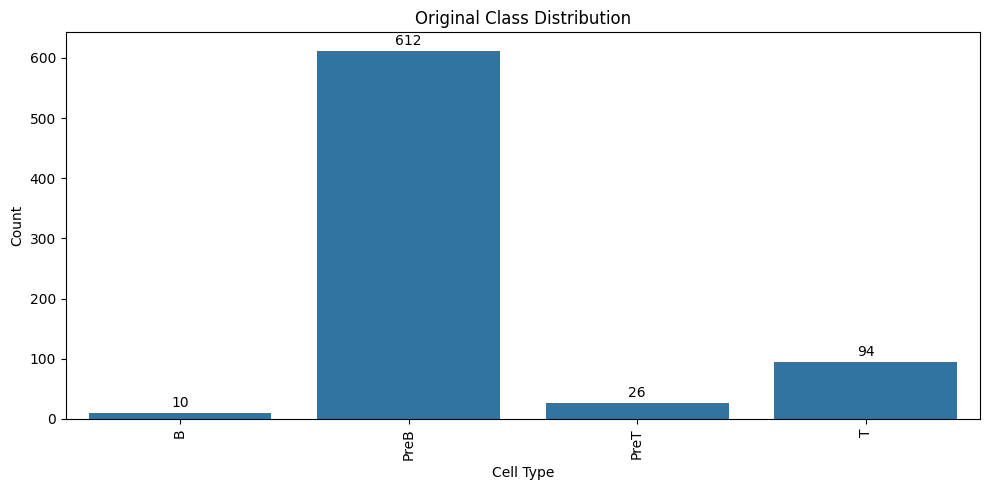

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

#################################################
# STEP 1: Load and preprocess data
#################################################

# Load dataset
df = pd.read_csv('input/ML_data.csv')
print(f"Original dataset shape: {df.shape}")

# Remove sample ID column
df = df.drop(columns=['Samples'])

# Remove unwanted cell types
df = df[~df['Cell_type'].isin(['Unknown'])]

# Convert cell type labels to numeric codes
le = LabelEncoder()
df['Cell_type'] = le.fit_transform(df['Cell_type'])
label_names = le.classes_
n_classes = len(label_names)
print(f"Number of classes: {n_classes}")
print(f"Names of classes: {label_names}")

# Normalize features between 0 and 1
feature_columns = df.columns[df.columns != 'Cell_type']
scaler = MinMaxScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Extract features and labels
X = df[feature_columns].values.astype(np.float32)
y = df['Cell_type'].values
input_dim = X.shape[1]

# Show class distribution
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.xlabel("Cell Type")
plt.xticks(range(n_classes), label_names, rotation=90)
plt.ylabel("Count")

# Add count labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5, f'{int(height)}', 
            ha='center', va='bottom')
plt.tight_layout()
plt.show()

## STEP 2 Prepare data for PyTorch


In [2]:
################################################
## STEP 2: Prepare data for PyTorch
#################################################

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)
y_onehot = F.one_hot(y_tensor, num_classes=n_classes).float()

# Create DataLoader for batch processing
dataset = TensorDataset(X_tensor, y_onehot)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# STEP 3: Define CVAE Model Components

In [ ]:
#################################################
# STEP 3: Define CVAE Model Components
#################################################

# Encoder - converts input data to latent space
class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, latent_dim, hidden_dim=512):
        super().__init__()
        # Neural network layers with more capacity and spectral normalization
        self.net = nn.Sequential(
            # First layer (input features + one-hot encoded labels)
            nn.Linear(input_dim + label_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(negative_slope=0.1),
            
            # Additional hidden layer for more capacity
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(negative_slope=0.1),
            
            # Second hidden layer
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.1)  # Reduced dropout
        )
        
        # Output layers for mean and log variance
        # Initialize with smaller weights to prevent initial KL collapse
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        
        # Initialize weights with smaller values
        with torch.no_grad():
            self.fc_mu.weight.data.normal_(0, 0.02)
            self.fc_logvar.weight.data.normal_(0, 0.02)

    def forward(self, x, y):
        # Combine features and labels
        xy = torch.cat([x, y], dim=1)
        h = self.net(xy)
        
        # Return mean and log variance with constraints
        # Constrain mu to avoid large values that cause instability
        mu = torch.tanh(self.fc_mu(h))
        
        # Constrain logvar to avoid extremely small variances
        # This helps prevent posterior collapse
        logvar = torch.clamp(self.fc_logvar(h), min=-4.0, max=4.0)
        
        return mu, logvar

# Decoder - converts latent representation back to data space
class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, output_dim, hidden_dim=512):
        super().__init__()
        # Neural network layers
        self.net = nn.Sequential(
            # First layer (latent vector + one-hot encoded labels)
            nn.Linear(latent_dim + label_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(negative_slope=0.1),
            
            # Second layer
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.2),  # Prevents overfitting
            
            # Output layer (reconstructs original features)
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, z, y):
        # Combine latent vector and labels
        zy = torch.cat([z, y], dim=1)
        # Generate reconstructed output
        return self.net(zy)

# Complete CVAE model
class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, latent_dim=16, hidden_dim=512):
        super().__init__()
        self.encoder = Encoder(input_dim, label_dim, latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, label_dim, input_dim, hidden_dim)
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + std * eps
        This makes the sampling process differentiable
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        # Encode input to get latent representation
        mu, logvar = self.encoder(x, y)
        # Sample from latent space
        z = self.reparameterize(mu, logvar)
        # Decode to reconstruct input
        x_recon = self.decoder(z, y)
        return x_recon, mu, logvar

#################################################
# STEP 4: Define Loss Function
#################################################

def loss_function(x_recon, x, mu, logvar, beta=1.0, kl_weight=1.0):
    """
    CVAE loss has two components:
    1. Reconstruction loss - how well the decoder reconstructs the input
    2. KL divergence - ensures latent space has good properties for sampling
    
    Added minimum KL weight to prevent posterior collapse
    """
    # Mean squared error between input and reconstruction
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    
    # KL divergence between latent distribution and normal distribution
    kld_raw = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Apply KL weight and ensure it doesn't go below minimum threshold
    # This prevents the KL term from becoming too small
    kld = max(kld_raw, kl_weight)
    
    # Total loss is reconstruction loss + beta * KL divergence
    return recon_loss + beta * kld, recon_loss, kld_raw

#################################################
# STEP 5: Training Function
#################################################

def train_cvae(model, dataloader, optimizer, epochs, device, beta_start=0.0, beta_end=1.0):
    """Train the CVAE model"""
    model.train()
    
    # Keep track of losses for plotting
    train_losses = []
    recon_history = []
    kl_history = []
    
    # Early stopping parameters
    best_loss = float('inf')
    patience = 20
    patience_counter = 0
    min_kl_weight = 0.001  # Minimum KL weight to prevent collapse
    
    for epoch in range(1, epochs + 1):
        total_loss = 0
        recon_losses = 0
        kl_losses = 0
        
        # Calculate beta for this epoch (cyclic annealing)
        # This helps prevent posterior collapse by periodically increasing beta
        cycle_size = epochs // 4
        cycle_position = (epoch - 1) % cycle_size
        beta = beta_start + (beta_end - beta_start) * (0.5 - 0.5 * np.cos(np.pi * cycle_position / cycle_size))
        
        for batch_idx, (x_batch, y_batch) in enumerate(dataloader):
            # Move data to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Forward pass
            x_recon, mu, logvar = model(x_batch, y_batch)
            
            # Calculate loss with minimum KL weight
            loss, recon_loss, kld = loss_function(x_recon, x_batch, mu, logvar, beta, min_kl_weight)
            
            # Add L2 regularization on encoder parameters to prevent mode collapse
            l2_reg = 0
            for param in model.encoder.parameters():
                l2_reg += torch.norm(param)
            loss += 0.0001 * l2_reg  # Small regularization factor
            
            # Backward pass and optimization
            loss.backward()
            
            # Gradient clipping to prevent training instability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Track losses
            total_loss += loss.item()
            recon_losses += recon_loss.item()
            kl_losses += kld.item()
        
        # Print epoch statistics
        avg_loss = total_loss / len(dataloader)
        avg_recon = recon_losses / len(dataloader)
        avg_kl = kl_losses / len(dataloader)
        
        train_losses.append(avg_loss)
        recon_history.append(avg_recon)
        kl_history.append(avg_kl)
        
        print(f"Epoch {epoch}/{epochs} | β={beta:.2f} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")
        
        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'cvae_model_best.pt')
        else:
            patience_counter += 1
            
        # Check if KL is collapsing and adjust if needed
        if avg_kl < 0.01 and epoch > 10:
            print("Warning: KL divergence is very low. Increasing minimum KL weight...")
            min_kl_weight *= 1.5  # Increase minimum KL weight
            
        # Break if no improvement for 'patience' epochs
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            # Load best model
            model.load_state_dict(torch.load('cvae_model_best.pt'))
            break
        
        # Visualize progress at intervals
        if epoch % 10 == 0 or epoch == epochs:
            visualize_samples(model, epoch, device)
    
    # Plot training losses
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title("Total Loss")
    plt.xlabel("Epoch")
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(recon_history)
    plt.title("Reconstruction Loss")
    plt.xlabel("Epoch")
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(kl_history)
    plt.title("KL Divergence")
    plt.xlabel("Epoch")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model

#################################################
# STEP 6: Generate Synthetic Samples
#################################################

def sample_cvae(model, class_id, num_samples, device):
    """Generate synthetic samples for a specific class"""
    model.eval()
    with torch.no_grad():
        # Create labels tensor for the desired class
        label_tensor = torch.tensor([class_id] * num_samples).to(device)
        one_hot = F.one_hot(label_tensor, num_classes=n_classes).float()
        
        # Sample from latent space
        z = torch.randn(num_samples, model.latent_dim).to(device)
        
        # Generate samples
        samples = model.decoder(z, one_hot)
    
    return samples.cpu().numpy()

#################################################
# STEP 7: Visualization Functions
#################################################

def visualize_samples(model, epoch, device):
    """Visualize samples from CVAE model"""
    # Count samples in each class
    class_counts = np.bincount(y)
    minority_classes = np.argsort(class_counts)[:3]  # Get 3 most minority classes
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Epoch {epoch}: Real vs Synthetic Samples (PCA)")
    
    for i, class_id in enumerate(minority_classes):
        # Generate synthetic samples
        n_samples = 200
        synthetic = sample_cvae(model, class_id, n_samples, device)
        
        # Get real samples
        real = X[y == class_id]
        
        # Combine real and synthetic for PCA
        combined = np.vstack([real, synthetic])
        labels = np.array(['Real'] * len(real) + ['Synthetic'] * len(synthetic))
        
        # Apply PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(combined)
        
        # Plot
        ax = axes[i]
        
        for label, color in zip(['Real', 'Synthetic'], ['orange', 'blue']):
            mask = labels == label
            ax.scatter(
                pca_result[mask, 0], 
                pca_result[mask, 1],
                alpha=0.6,
                color=color,
                label=label
            )
        
        ax.set_title(f"Class: {label_names[class_id]}")
        ax.legend()
    
    plt.tight_layout()
    plt.show()
def generate_balanced_dataset(model, device, target_samples_per_class=None, return_fake_only=False):
    """Generate a balanced dataset using CVAE"""
    if target_samples_per_class is None:
        # Set target to maximum number of samples in any class
        target_samples_per_class = max(np.bincount(y))
    
    print(f"Creating balanced dataset with {target_samples_per_class} samples per class")
    
    synthetic_data = []
    synthetic_labels = []
    
    for class_id in range(n_classes):
        # Count real samples for this class
        real_count = np.sum(y == class_id)
        
        # Calculate how many synthetic samples we need
        if real_count < target_samples_per_class:
            needed = target_samples_per_class - real_count
            
            # Generate synthetic samples
            print(f"Generating {needed} synthetic samples for class {class_id} ({label_names[class_id]})")
            synthetic = sample_cvae(model, class_id, needed, device)
            
            # Store samples and labels
            synthetic_data.append(synthetic)
            synthetic_labels.extend([class_id] * needed)
    
    if synthetic_data:
        # Combine synthetic data
        synthetic_data = np.vstack(synthetic_data)
        synthetic_labels = np.array(synthetic_labels)

        if return_fake_only:
            print(f"Returning only {len(synthetic_data)} synthetic samples")
            return synthetic_data, synthetic_labels
        
        # Combine with real data
        balanced_X = np.vstack([X, synthetic_data])
        balanced_y = np.concatenate([y, synthetic_labels])
        
        print(f"Created balanced dataset with {len(balanced_X)} samples")
        
        # Visualize new class distribution
        plt.figure(figsize=(10, 5))
        ax = sns.countplot(x=balanced_y)
        plt.title("Balanced Class Distribution (Real + Synthetic)")
        plt.xlabel("Cell Type")
        plt.xticks(range(n_classes), label_names, rotation=90)
        plt.ylabel("Count")
        
        # Add count labels on bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2, height + 5, f'{int(height)}', 
                    ha='center', va='bottom')
        plt.tight_layout()
        plt.show()
        
        return balanced_X, balanced_y
    else:
        print("No synthetic samples needed - dataset already balanced")
        return (synthetic_data, synthetic_labels) if return_fake_only else (X, y)


# Main script to run the model

Starting training...
Epoch 1/100 | β=0.00 | Loss: 0.2119 | Recon: 0.2015 | KL: 0.0961
Epoch 2/100 | β=0.00 | Loss: 0.1141 | Recon: 0.1029 | KL: 0.1833
Epoch 3/100 | β=0.02 | Loss: 0.0951 | Recon: 0.0808 | KL: 0.2471
Epoch 4/100 | β=0.04 | Loss: 0.0885 | Recon: 0.0690 | KL: 0.2579
Epoch 5/100 | β=0.06 | Loss: 0.0866 | Recon: 0.0653 | KL: 0.1763
Epoch 6/100 | β=0.10 | Loss: 0.0797 | Recon: 0.0638 | KL: 0.0577
Epoch 7/100 | β=0.14 | Loss: 0.0757 | Recon: 0.0627 | KL: 0.0195
Epoch 8/100 | β=0.18 | Loss: 0.0712 | Recon: 0.0590 | KL: 0.0102
Epoch 9/100 | β=0.23 | Loss: 0.0683 | Recon: 0.0564 | KL: 0.0070
Epoch 10/100 | β=0.29 | Loss: 0.0658 | Recon: 0.0540 | KL: 0.0051


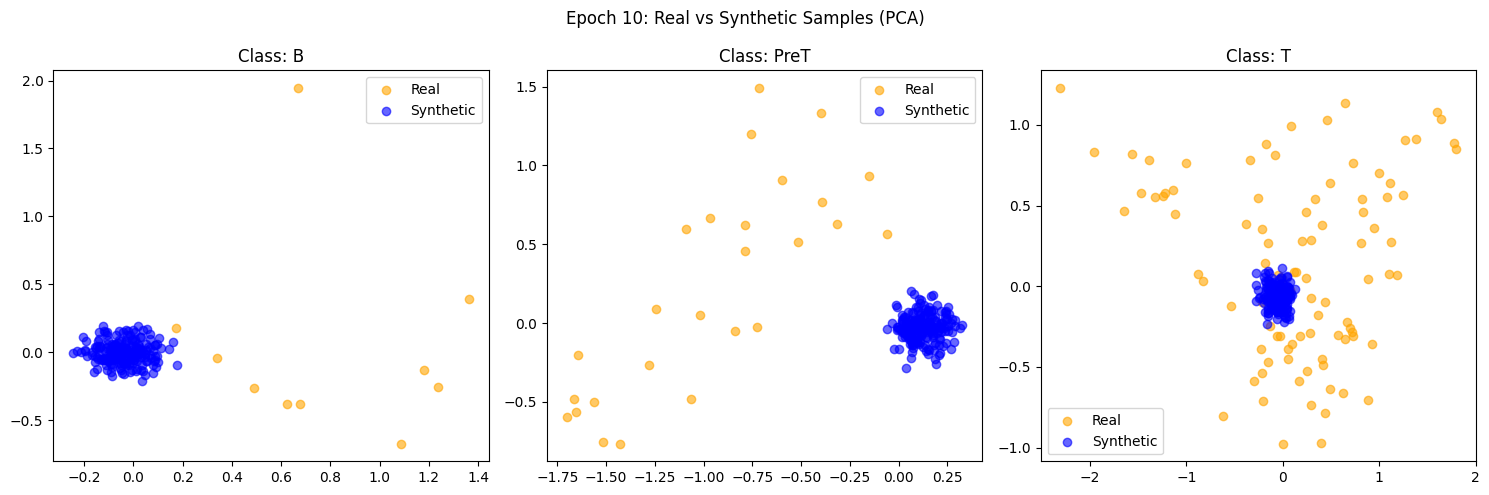

Epoch 11/100 | β=0.35 | Loss: 0.0463 | Recon: 0.0356 | KL: 0.0010
Epoch 12/100 | β=0.41 | Loss: 0.0460 | Recon: 0.0350 | KL: 0.0013
Epoch 13/100 | β=0.47 | Loss: 0.0460 | Recon: 0.0348 | KL: 0.0008
Epoch 14/100 | β=0.53 | Loss: 0.0464 | Recon: 0.0344 | KL: 0.0025
Epoch 15/100 | β=0.59 | Loss: 0.0471 | Recon: 0.0339 | KL: 0.0016
Epoch 16/100 | β=0.65 | Loss: 0.0490 | Recon: 0.0339 | KL: 0.0036
Epoch 17/100 | β=0.71 | Loss: 0.0519 | Recon: 0.0336 | KL: 0.0075
Epoch 18/100 | β=0.77 | Loss: 0.0571 | Recon: 0.0339 | KL: 0.0082
Epoch 19/100 | β=0.82 | Loss: 0.0651 | Recon: 0.0339 | KL: 0.0187
Epoch 20/100 | β=0.86 | Loss: 0.0657 | Recon: 0.0333 | KL: 0.0132


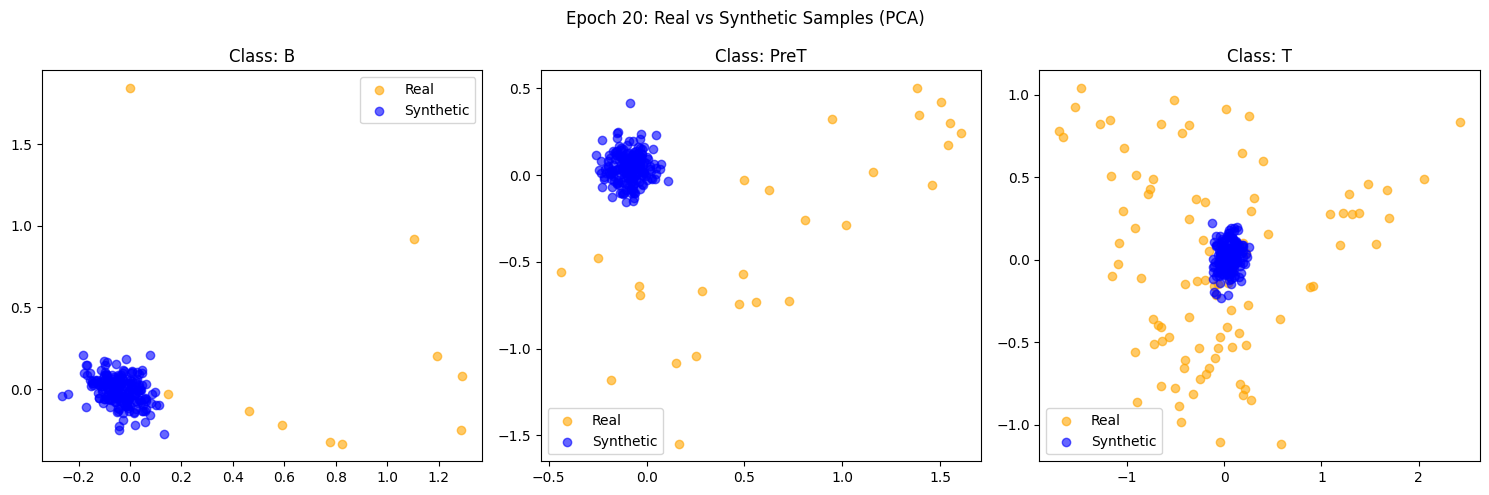

Epoch 21/100 | β=0.90 | Loss: 0.0663 | Recon: 0.0331 | KL: 0.0091
Epoch 22/100 | β=0.94 | Loss: 0.0794 | Recon: 0.0333 | KL: 0.0089
Early stopping at epoch 22


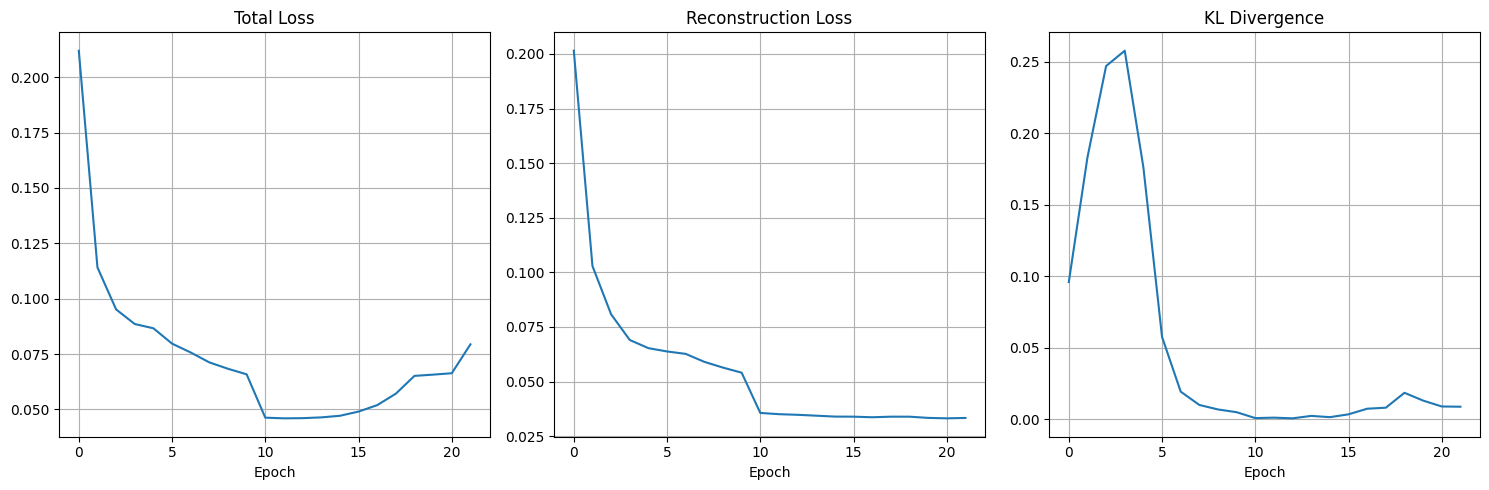

Creating balanced dataset with 612 samples per class
Generating 602 synthetic samples for class 0 (B)
Generating 586 synthetic samples for class 2 (PreT)
Generating 518 synthetic samples for class 3 (T)
Created balanced dataset with 2448 samples


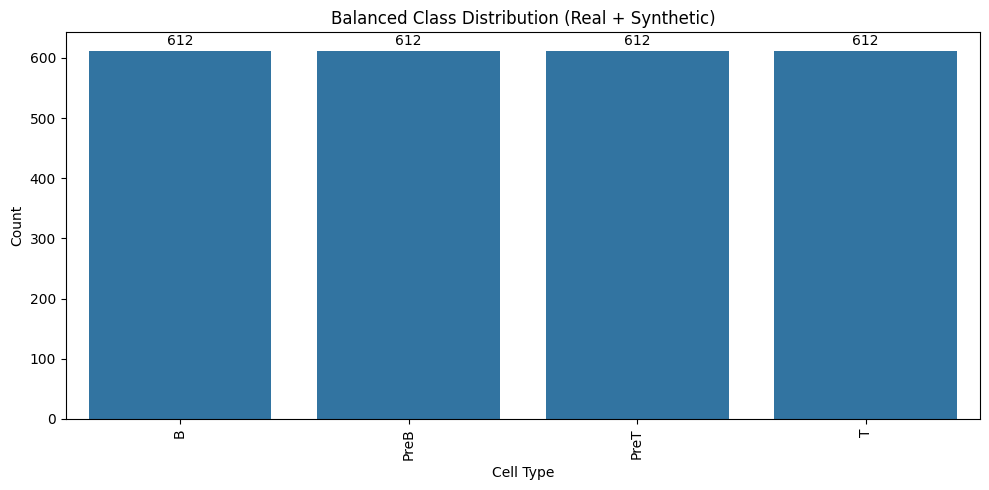

Model saved to 'cvae_model.pt'


In [20]:
# Set hyperparameters
latent_dim = 64  # Dimension of latent space
hidden_dim = 512  # Size of hidden layers
learning_rate = 5e-4  # Lower learning rate for stability
epochs = 100  # Train longer with early stopping

# Initialize CVAE model
model = CVAE(
    input_dim=X.shape[1],
    label_dim=n_classes,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim
).to(device)

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert data to tensors and create DataLoader
X_tensor = torch.tensor(X).to(device)
y_tensor = torch.tensor(y).to(device)
y_onehot = F.one_hot(y_tensor, num_classes=n_classes).float()

dataset = TensorDataset(X_tensor, y_onehot)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Train model
print("Starting training...")
model = train_cvae(model, dataloader, optimizer, epochs, device, beta_start=0.0, beta_end=1.0)

# Generate balanced dataset
balanced_X, balanced_y = generate_balanced_dataset(model, device)

# Combine into a DataFrame
balanced_df = pd.DataFrame(balanced_X, columns=feature_columns)
balanced_df["Cell_type"] = balanced_y

balanced_df.head()

# Save the model
torch.save(model.state_dict(), 'cvae_model.pt')
print("Model saved to 'cvae_model.pt'")


Creating balanced dataset with 612 samples per class
Generating 602 synthetic samples for class 0 (B)
Generating 586 synthetic samples for class 2 (PreT)
Generating 518 synthetic samples for class 3 (T)
Returning only 1706 synthetic samples
Creating balanced dataset with 612 samples per class
Generating 602 synthetic samples for class 0 (B)
Generating 586 synthetic samples for class 2 (PreT)
Generating 518 synthetic samples for class 3 (T)
Created balanced dataset with 2448 samples


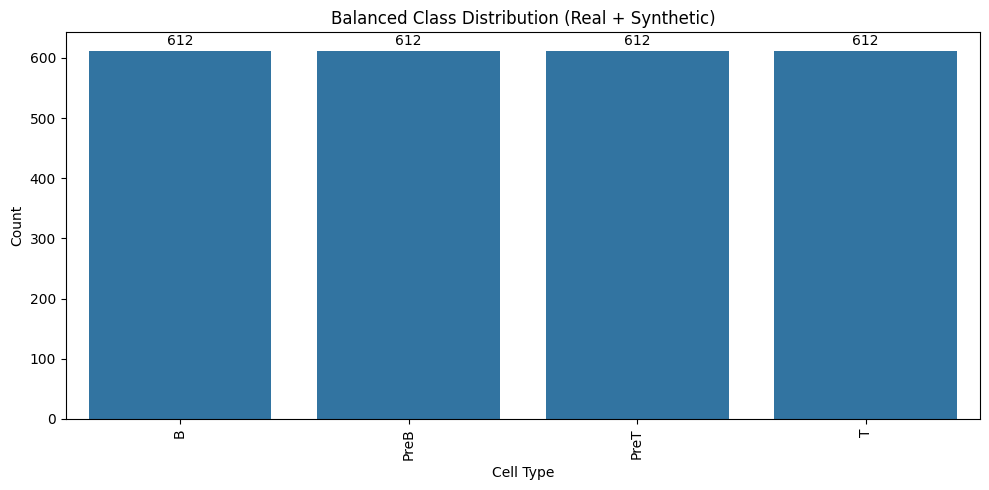

In [22]:

# Generate balanced dataset
balanced_X, balanced_y = generate_balanced_dataset(model, device, return_fake_only = True)

# Combine into a DataFrame
balanced_df = pd.DataFrame(balanced_X, columns=feature_columns)
balanced_df["Cell_type"] = balanced_y

# Reconvert to original labels
balanced_df["Cell_type"] = le.inverse_transform(balanced_df["Cell_type"].astype(int))
# Save to CSV
balanced_df.to_csv("synthetic_balanced_dataset.csv", index=False)

balanced_df

# Generate balanced dataset
balanced_X, balanced_y = generate_balanced_dataset(model, device, return_fake_only = False)

# Combine into a DataFrame
balanced_df = pd.DataFrame(balanced_X, columns=feature_columns)
balanced_df["Cell_type"] = balanced_y

# Reconvert to original labels
balanced_df["Cell_type"] = le.inverse_transform(balanced_df["Cell_type"].astype(int))
# Save to CSV
balanced_df.to_csv("synthetic_balanced_dataset_ALL.csv", index=False)
